# <center> ccdproc
        
### <center> Anika Slizewski
    
This notebook touches on *some* of the functions you will use from the ccdproc package to handle CCDData objects.
- ccdproc data reduction: https://ccdproc.readthedocs.io/en/latest/ 
- CCDData class: https://docs.astropy.org/en/stable/api/astropy.nddata.CCDData.html#astropy.nddata.CCDData 

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from ccdproc import CCDData, trim_image, subtract_bias, subtract_dark, flat_correct, Combiner, subtract_overscan

import astropy.units as u
from astropy.visualization import simple_norm, ImageNormalize, ZScaleInterval

import warnings
warnings.simplefilter("ignore") #if you want to ignore the warnings lol


## Read in your files with CCDData.read
Requires unit = ‘adu’ or ‘electron’ or ‘photon’, or no units with u.dimensionless_unscaled

In [3]:
image = CCDData.read('./Images/Saturn.0029r.fits',unit='adu')
bias_1 = CCDData.read('./Images/bias.0007r.fits',unit='adu')
bias_2 = CCDData.read('./Images/bias.0008r.fits',unit='adu')

# To call header info:
fltr = image.header['filter']

# To print the header:
image.header

SIMPLE  =                    T                                                  
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 2098                                                  
NAXIS2  =                 1078                                                  
OBSERVAT= 'APO'                / Per the IRAF observatory list.                 
TELESCOP= '3.5m'                                                                
INSTRUME= 'DIS'                / Instrument name                                
LATITUDE= +3.2780361000000E+01 / Latitude of telescope base                     
LONGITUD= -1.0582041700000E+02 / Longitude of telescope base                    
UTC-TAI = -37.0                / UTC = TAI + UTC_TAI(seconds)                   
UT1-TAI = -37.15               / UT1 = TAI + UT1_TAI(seconds)                   
LST     = '17:29:10.982'    

There a tons of ways to scale plots, below are a few:

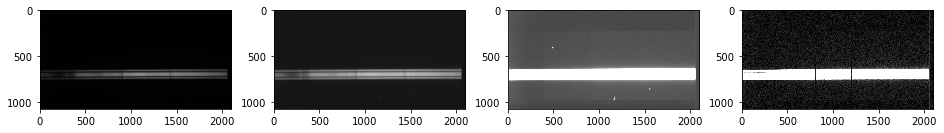

In [5]:
norm = simple_norm(image, 'sqrt')

znorm = ImageNormalize(image,interval=ZScaleInterval())

vmin=np.percentile(image,5)
vmax=np.percentile(image,90)

plt.figure(figsize=(13,12),constrained_layout=True)

plt.subplot(1,4,1)
plt.imshow(image,cmap='gray') #Want to change the orentation, add origin='lower'

plt.subplot(1,4,2)
plt.imshow(image,norm=norm,cmap = 'gray')

plt.subplot(1,4,3)
plt.imshow(image,norm=znorm,cmap = 'gray')

plt.subplot(1,4,4)
plt.imshow(image,vmin=vmin,vmax=vmax,cmap='gray',interpolation='nearest');
    
# Also many different color maps -- https://matplotlib.org/stable/tutorials/colors/colormaps.html
# and other ways to visualize your images -- https://docs.astropy.org/en/stable/visualization/normalization.html

## Combining images
Combiner objects can be combined from the **median** or the average of the images. It also can reject pixels
based on min/max or a sigma threshold.

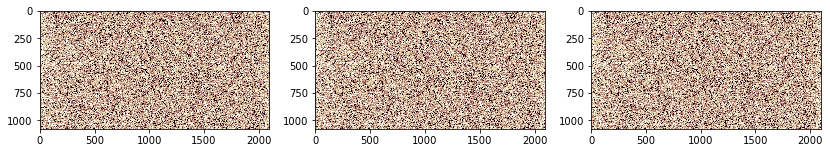

In [6]:
# Must call array ([]) of files you want to combine, see 
# https://ccdproc.readthedocs.io/en/latest/api/ccdproc.Combiner.html
biases = Combiner([bias_1,bias_2]) 
master_bias = biases.median_combine() # Could also clip extrema with sigma or minmax thresholds
master_bias.header = bias_1.header #Try to keep the header meta data
master_bias.header['Combined'] = 'Combined with bias_1 and bias_2'

plt.figure(figsize=(14,12))
plt.subplot(1,3,1)
plt.imshow(bias_1,vmin=np.percentile(bias_1,5),vmax=np.percentile(bias_1,95),interpolation='nearest',cmap='pink')
plt.subplot(1,3,2)
plt.imshow(bias_2,vmin=np.percentile(bias_2,5),vmax=np.percentile(bias_2,95),interpolation='nearest',cmap='pink')
plt.subplot(1,3,3)
plt.imshow(master_bias,vmin=np.percentile(master_bias,5),vmax=np.percentile(master_bias,90),interpolation='nearest',cmap='pink');

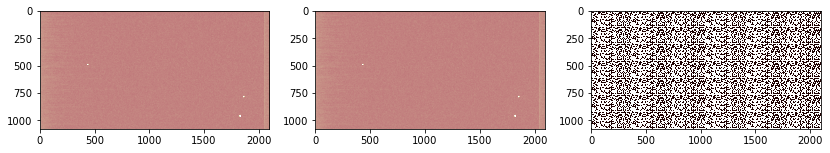

In [7]:
plt.figure(figsize=(14,12))
plt.subplot(1,3,1)
plt.imshow(bias_1,norm=ImageNormalize(bias_1,interval=ZScaleInterval()),cmap='pink')
plt.subplot(1,3,2)
plt.imshow(master_bias,norm=ImageNormalize(master_bias,interval=ZScaleInterval()),cmap='pink')
plt.subplot(1,3,3)
plt.imshow(master_bias.subtract(bias_1),norm=ImageNormalize((master_bias.subtract(bias_1)),interval=ZScaleInterval()),cmap='pink')

In [ ]:
master_bias.header

## Arithmetic

Using CCDData functions will (usually) save the meta data.

- CCDData attributes and methods/operations: https://docs.astropy.org/en/stable/api/astropy.nddata.CCDData



In [1]:
bias_sub = subtract_bias(image,master_bias,add_keyword=True) 

# Same process for adding, dividing, and multiplying.
# bias_sub = image.subtract(master_bias,handle_meta='first_found')
# bias_sub = CCDData.subtract(image,master_bias)
# bias_sub.header = image.header

bias_sub.header

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.title('Raw Image')
plt.imshow(image, cmap='pink',norm=ImageNormalize(image,interval=ZScaleInterval()))
plt.subplot(1,3,2)
plt.title('Raw Bias')
plt.imshow(master_bias,cmap='pink',norm=ImageNormalize(master_bias,interval=ZScaleInterval()))
plt.subplot(1,3,3)
plt.title('Bias Subtracted Image')
plt.imshow(bias_sub,cmap='pink',norm=ImageNormalize(bias_sub,interval=ZScaleInterval()));

NameError: name 'subtract_bias' is not defined

In [9]:
# Some other attributes:
print(bias_1.shape)
# To write images, use image.write('name.fits')

(1078, 2098)


#### Some tips for the rest of your work:

- subtract_dark and subtract_bias both use CCDData arithmetic to subtract the master
dark/bias
- flat_correct normalizes the flat and divides it out (does two steps in one :D) , see https://ccdproc.readthedocs.io/en/latest/api/ccdproc.flat_correct.html#ccdproc.flat_correct)
- try to keep header info in your final image!

### Overscan? Need to trim?

In [ ]:
temp = trim_image(bias_sub,fits_section=image.header['DATASEC'])
print(bias_sub.shape,temp.shape)